In [2]:
import keras
import shutil
# -*- coding: utf-8 -*-
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
import os
from PIL import Image
from keras.preprocessing.image import *
from annoy import AnnoyIndex


DATA_PATH="classifieds/"
TRAIN_PATH=DATA_PATH+"train/"
VALID_PATH=DATA_PATH+"validation/"

# модель = ResNet50 без голови з одним dense шаром для класифікації об'єктів на nb_classes

In [15]:
def get_model(cls=844):
    feature_extractor = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    flat = Flatten()(feature_extractor.output)
    # можна додати кілька dense шарів:
    # d = Dense(nb_classes*2, activation='relu')(flat)
    # d = Dense(nb_classes, activation='softmax')(d)
    # d = Dense(cls, activation='softmax')(flat)
    m = Model(inputs=feature_extractor.input, outputs=flat)

    # "заморозимо" всі шари ResNet50, крім кількох останніх
    # базові ознаки згорткових шарів перших рівнів досить універсальні, тому ми не будемо міняти їх ваги
    # кількість шарів, які ми "заморожуємо" - це гіперпараметр
    for layer in m.layers[:-12]:
        layer.trainable = False

    # для finetuning ми використаємо звичайний SGD з малою швидкістю навчання та моментом
    m.compile(
        optimizer=SGD(lr=0.0001, momentum=0.9),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    m.summary()
    return m



In [ ]:
# кількість класів, підставте ваше значення
nb_classes = 844

model = get_model(cls=nb_classes)

# при необхідності завантажити ваги:
# model.load_weights('weights_finetuned.h5')

img_height = 224
img_width = 224
batch_size = 8

# розділити датасет на тренувальний та тестовий
# у пропорції 90/10
train_dir = 'classifieds/train'
test_dir = 'classifieds/test'

# зробити генератор за рекомендаціями статті:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

train_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical")

'''model.fit_generator(
    generator=train_generator,
    # validation_data= напишіть генератор для тестових даних
    steps_per_epoch=42,
    nb_epoch=42,
    callbacks=[ModelCheckpoint('weights_finetuned.h5', save_best_only=True, monitor='val_loss')])

model.save_weights('weights_finetuned.h5')
'''


In [6]:
vector_size=2048
threshold_dist=1.15
valid_size=0.1
annoy_global = AnnoyIndex(vector_size,metric='angular')
counter_global=0

In [3]:
def data_cleaning_with_validset_creation(vector_size,threshold_dist,valid_size):
    
    for direct in os.listdir(TRAIN_PATH):
        #clean_data(direct,vector_size,threshold_dist)
        move_to_validation(direct,valid_size)
         

In [392]:
def clean_data(direct,vector_size,threshold_dist,include=True):
        if include:
            print(direct)
            annoy_local = AnnoyIndex(vector_size,metric='angular')
            counter_local=0
            images= os.listdir(TRAIN_PATH+direct)
            images_len = len(images)
            threshold_val=images_len*threshold_dist
            distances=np.zeros(images_len)

            for img in images:
                img = preprocess_input(img_to_array(load_img(TRAIN_PATH+direct+"/"+img,target_size=(224,224))))
                img = np.expand_dims(img,axis=0)
                prediction = np.reshape(model.predict(img),vector_size)
                annoy_local.add_item(counter_local,prediction)
                counter_local+=1

            annoy_local.build(4)

            for i in range(images_len): 
                vals,distance=annoy_local.get_nns_by_item(i,images_len,search_k=-1,include_distances=True)
                for index,val in enumerate(vals):
                    distances[val]+=distance[index]

            dictionary =dict(enumerate(distances))
            dist_arr =[(num,dist) for num,dist in dictionary.items() if dist>images_len*threshold_dist]
            pathes_remove =[images[val[0]] for val in dist_arr]

            for path in pathes_remove:
                os.remove(TRAIN_PATH+direct+"/"+path)
                images_len-=1
        else:
            pass

In [4]:
def move_to_validation(direct,valid_size):
    
    images = os.listdir(TRAIN_PATH+direct)
    #insert_to_annoy(images,direct)
    images_len = len(images)    
    validation_images = images[:int(valid_size*images_len)]
    new_dir = VALID_PATH+direct
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    for img in validation_images:
        shutil.move(TRAIN_PATH+direct+"/"+img,new_dir+"/"+img)
        
    

In [394]:
def insert_to_annoy(images,direct):
    global counter_global
    for img in images:
        img = preprocess_input(img_to_array(load_img(TRAIN_PATH+direct+"/"+img,target_size=(224,224))))
        img = np.expand_dims(img,axis=0)
        prediction = np.reshape(model.predict(img),vector_size)
        annoy_global.add_item(counter_global,prediction)
        counter_global+=1
        
        

    

In [7]:
data_cleaning_with_validset_creation(vector_size,threshold_dist,valid_size)

OSError: [Errno 2] No such file or directory: 'classifieds/train/'

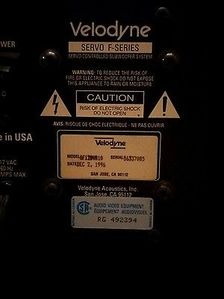

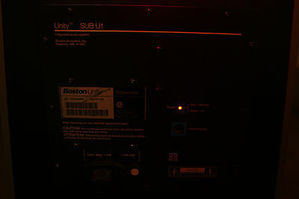

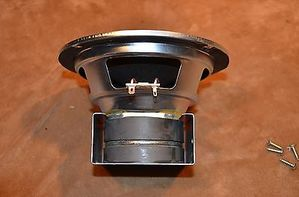

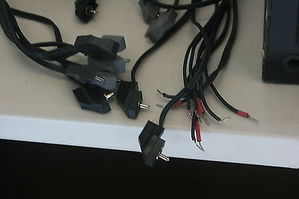

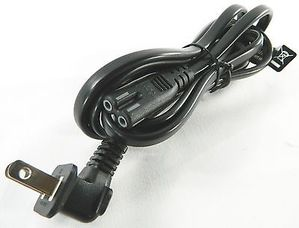

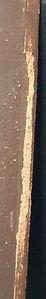

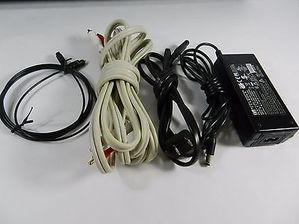

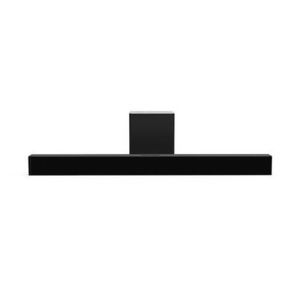

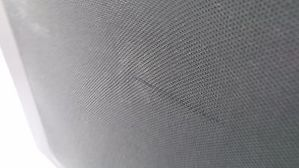

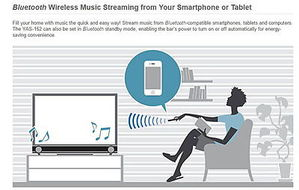

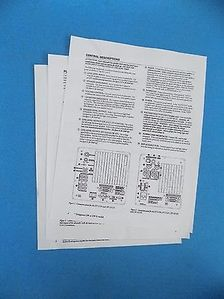

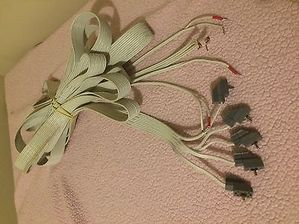

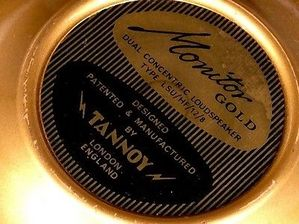

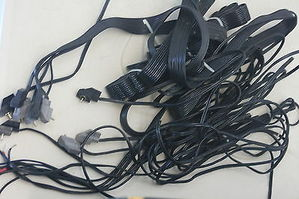

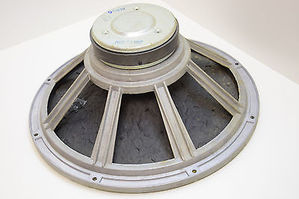

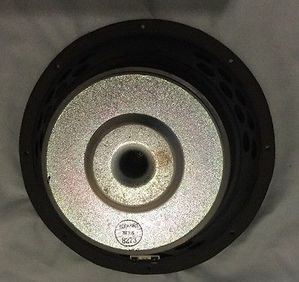

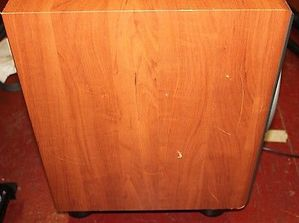

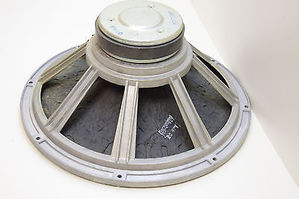

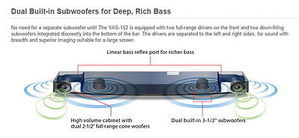

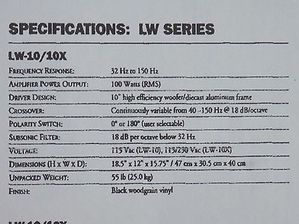

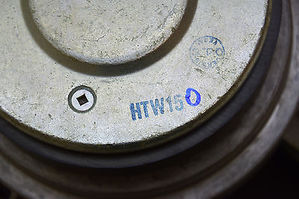

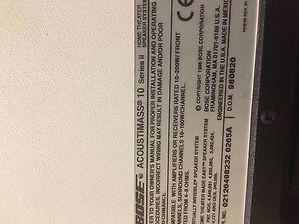

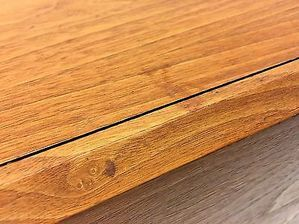

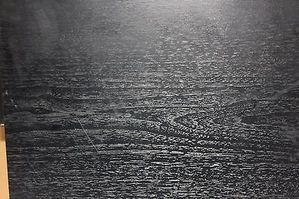

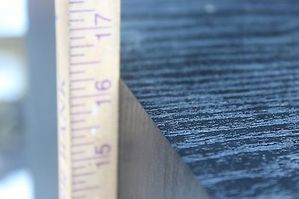

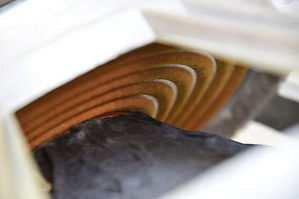

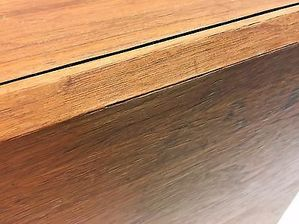

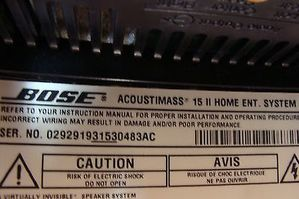

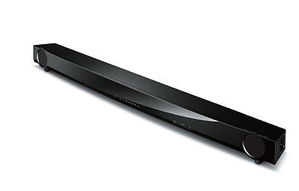

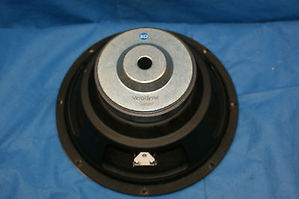

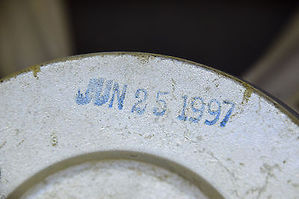

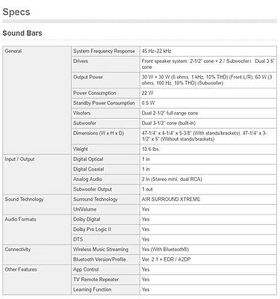

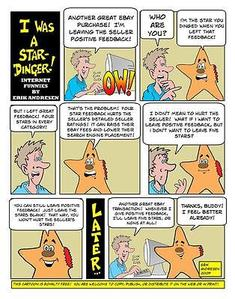

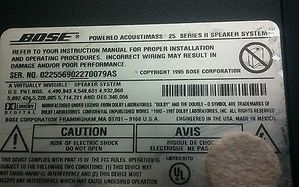

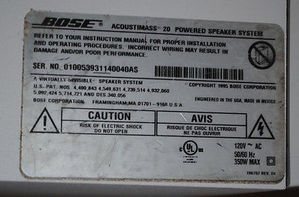

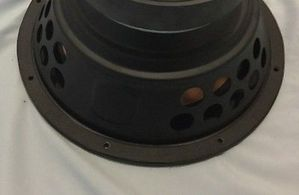

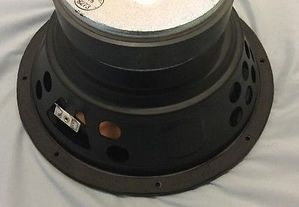

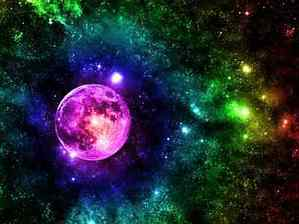

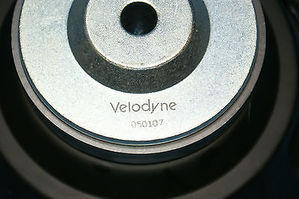

In [340]:
from IPython.display import Image
for path in pathes:
    display(Image(TRAIN_PATH+"109_Electronics_Subwoofer/"+path, retina=True))
    